<a href="https://colab.research.google.com/github/arose13/Notebooks/blob/master/Siamese%20Network%20-%20Simple%20Contrastive%20Loss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow.keras as k
import tensorflow.keras.backend as K
from tensorflow.keras.layers import (
    Input,
    Flatten, 
    Activation,
    Dense, 
    Conv2D, 
    MaxPool2D, 
    BatchNormalization,
    Concatenate,
)
from tensorflow.keras import callbacks
from tensorflow.keras import activations
from tensorflow.keras.utils import plot_model

import matplotlib.pyplot as graph
import seaborn as sns

from tqdm.auto import trange, tqdm


def append_none(tup):
    return tuple([None] + list(tup))

def remove_none(tup):
    return tuple(a for a in tup if a is not None)


def plot_number(xi, yi=''):
    graph.figure(figsize=(1, 1))
    graph.title('{}'.format(yi))
    graph.imshow(xi.reshape(28, 28), cmap='Greys')
    graph.xticks([])
    graph.yticks([])
    graph.grid(False)
    graph.show()

# Setup

In [2]:
(x_train, y_train), (x_test, y_test) = k.datasets.mnist.load_data()
x_train, x_test = (a/255 for a in (x_train, x_test))

print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)

11493376/11490434 [==============================] - 0s 0us/step
(60000, 28, 28) (10000, 28, 28)
(60000,) (10000,)


[    0    11    35 ... 59968 59993 59997]


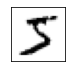

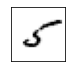

In [3]:
locations = {i: np.where(y_train == i)[0] for i in np.unique(y_train)}

print(locations[5])

plot_number(x_train[0])
plot_number(x_train[11])

Techically I should remove `i` from the list but with a large sample size selecting the same image twice should rarely occur.

In [4]:
# Convert this to a pair generator at some point
def generate_pairs(data, labels):
    pair_images = []
    pair_targets = []
    label_set = np.unique(labels)
    
    # Final all unique types
    locations = {i: np.where(labels == i)[0] for i in np.unique(labels)}
    for i in trange(len(labels)):
        data_i = np.expand_dims(data[i], 2)
        label_i = labels[i]
        not_label_i = label_set.copy()
        not_label_i = not_label_i[not_label_i != label_i]

        # Pair i with a random matched i from the location list (can we do better than random?)
        pair_images.append([
            data_i, 
            np.expand_dims(
                data[np.random.choice(locations[label_i])],
                2
            )
        ]) 
        pair_targets.append(1) 

        # Select negative image pair
        pair_images.append([
            data_i,
            np.expand_dims(
               data[np.random.choice(locations[np.random.choice(not_label_i)])],
               2
            )
        ])
        pair_targets.append(0)
    
    return pair_images, pair_targets


def create_x_y(pair_data, pair_target):
    x_left = np.array([pair[0] for pair in tqdm(pair_data, desc='Left Images')])
    x_right = np.array([pair[1] for pair in tqdm(pair_data, desc='Right Images')])
    y = np.array(pair_target)
    return [x_left, x_right], y


pair_train_data, pair_train_targets = generate_pairs(x_train, y_train)
pair_test_data, pair_test_targets = generate_pairs(x_test, y_test)

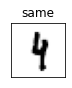

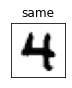

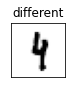

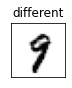

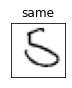

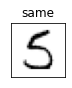

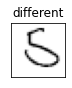

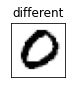

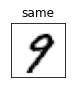

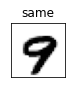

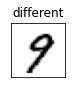

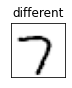

In [5]:
for w in np.random.choice(np.arange(int(len(pair_train_data) / 2)), size=3):
    even = 2*w
    odd = 2*w + 1

    plot_number(pair_train_data[even][0], 'same')
    plot_number(pair_train_data[even][1], 'same')

    plot_number(pair_train_data[odd][0], 'different')
    plot_number(pair_train_data[odd][1], 'different')

# Create Model

(Is this a true siamese nerual network?)

In [6]:
3 # Setup
input_shape = pair_train_data[0][0].shape
print('Input shape', input_shape)
print(append_none(input_shape))

Input shape (28, 28, 1)
(None, 28, 28, 1)


Model: "BaseModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 24, 24, 32)        832       
_________________________________________________________________
batch_normalization (BatchNo (None, 24, 24, 32)        128       
_________________________________________________________________
activation (Activation)      (None, 24, 24, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 10, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 10, 10, 64)        25

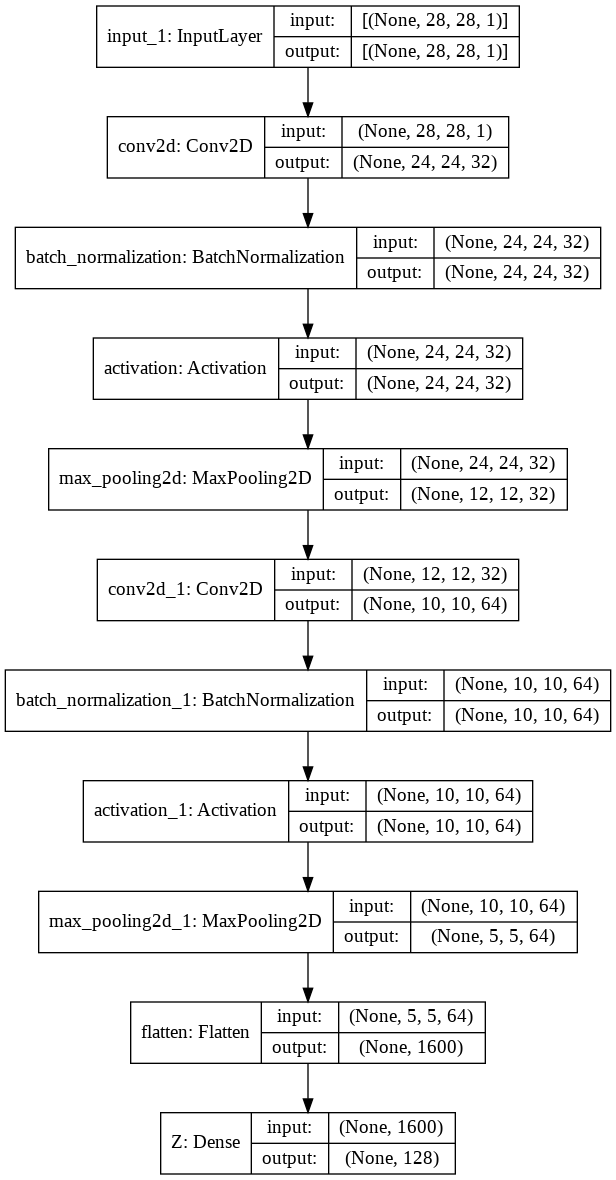

In [7]:
# Create Base Model
base_input = Input(shape=input_shape)

z_model = Conv2D(32, kernel_size=(5, 5), input_shape=input_shape)(base_input)
z_model = BatchNormalization()(z_model)
z_model = Activation(activation=activations.selu)(z_model)
z_model = MaxPool2D(pool_size=(2, 2))(z_model)

z_model = Conv2D(64, kernel_size=(3, 3))(z_model)
z_model = BatchNormalization()(z_model)
z_model = Activation(activation=activations.selu)(z_model)
z_model = MaxPool2D(pool_size=(2, 2))(z_model)

z_model = Flatten()(z_model)
z_model = Dense(128, name='Z')(z_model)

base_model = k.Model(base_input, z_model, name='BaseModel')

print(base_model.summary())
display(plot_model(base_model, show_shapes=True))

Model: "DistanceNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 256)          0           input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 8)            2056        concatenate[0][0]      

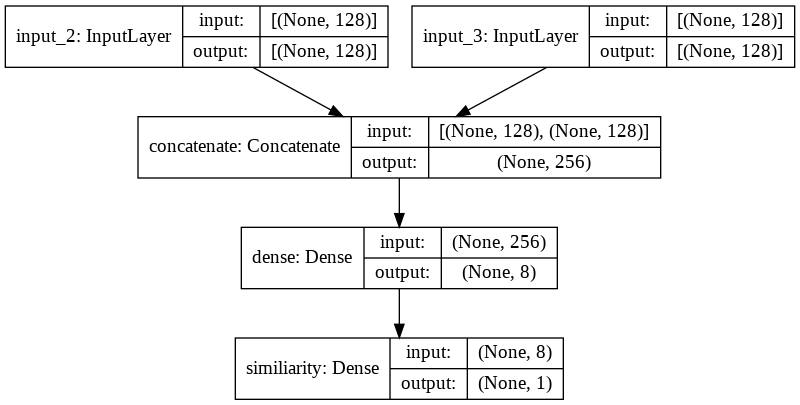

In [8]:
# Create metric learner
input_left = Input(shape=remove_none(base_model.output_shape))
input_right = Input(shape=remove_none(base_model.output_shape))

distance_net = Concatenate(axis=1)([input_left, input_right])
distance_net = Dense(8, activation=activations.selu)(distance_net)
distance_net = Dense(1, activation=activations.sigmoid, name='similiarity')(distance_net)

distance_model = k.Model([input_left, input_right], distance_net, name='DistanceNet')
print(distance_model.summary())
display(plot_model(distance_model, show_shapes=True))

Model: "SiameseNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input-left (InputLayer)         [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
input-right (InputLayer)        [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
BaseModel (Functional)          (None, 128)          224640      input-left[0][0]                 
                                                                 input-right[0][0]                
__________________________________________________________________________________________________
DistanceNet (Functional)        (None, 1)            2065        BaseModel[0][0]         

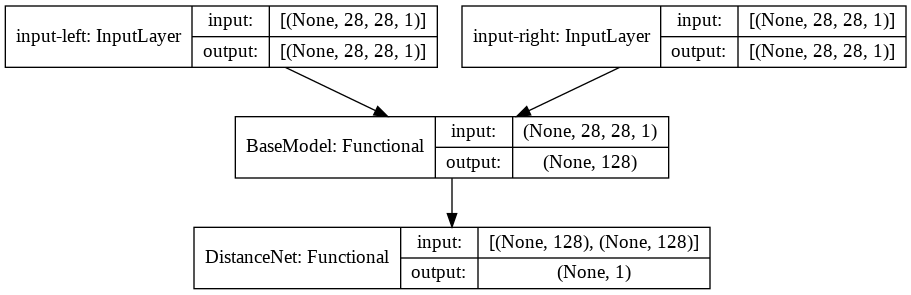

In [9]:
# Final Model
input_a = Input(shape=input_shape, name='input-left')
input_b = Input(shape=input_shape, name='input-right')

z_a = base_model(input_a)
z_b = base_model(input_b)

distance_leaner = distance_model([z_a, z_b])
final_model = k.Model([input_a, input_b], distance_leaner, name='SiameseNet')
print(final_model.summary())
display(plot_model(final_model, show_shapes=True))

# Pre Model Fitting

In [10]:
x_train, y_train = create_x_y(pair_train_data, pair_train_targets)

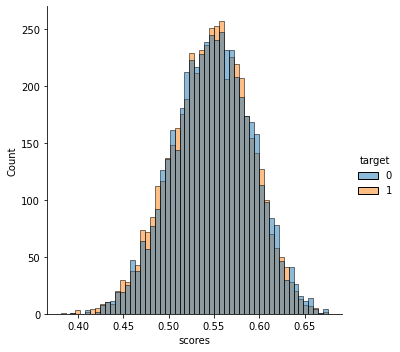

In [11]:
df_before = pd.DataFrame(
    final_model.predict(x_train)[:10_000],
    columns=['scores']
)
df_before['target'] = y_train[:10_000]

sns.displot(df_before, x='scores', hue='target')
graph.show()

# Model Fitting

This version of a siamese network is really just a classifier between the 2 images and the model tries to learn what makes the 2 embeddings different.

Because of the this a simple binary cross entropy is all that's needed as a loss function. Baseline accuracy is always 50% and it can improve from there.

In [12]:
final_model.compile(
    optimizer=k.optimizers.SGD(1e-2),
    loss=k.losses.binary_crossentropy,
    metrics=[
        k.metrics.BinaryAccuracy()
    ],
)

hist = final_model.fit(
    x_train, y_train,
    batch_size=512,
    epochs=1000,
    validation_split=0.2,
    callbacks=[
        callbacks.ReduceLROnPlateau(factor=0.5, patience=5, verbose=1, min_lr=1e-6),
        callbacks.EarlyStopping(patience=10, restore_best_weights=True)
    ]
)

Epoch 1/1000
188/188 [==============================] - 7s 27ms/step - loss: 0.6436 - binary_accuracy: 0.6069 - val_loss: 0.7765 - val_binary_accuracy: 0.5458
Epoch 2/1000
188/188 [==============================] - 4s 24ms/step - loss: 0.5149 - binary_accuracy: 0.7446 - val_loss: 0.4661 - val_binary_accuracy: 0.7818
Epoch 3/1000
188/188 [==============================] - 5s 25ms/step - loss: 0.4378 - binary_accuracy: 0.7987 - val_loss: 0.4061 - val_binary_accuracy: 0.8159
Epoch 4/1000
188/188 [==============================] - 5s 24ms/step - loss: 0.3955 - binary_accuracy: 0.8238 - val_loss: 0.3738 - val_binary_accuracy: 0.8346
Epoch 5/1000
188/188 [==============================] - 5s 24ms/step - loss: 0.3671 - binary_accuracy: 0.8395 - val_loss: 0.3478 - val_binary_accuracy: 0.8504
Epoch 6/1000
188/188 [==============================] - 5s 24ms/step - loss: 0.3423 - binary_accuracy: 0.8538 - val_loss: 0.3315 - val_binary_accuracy: 0.8553
Epoch 7/1000
188/188 [========================

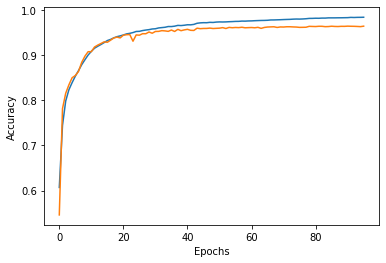

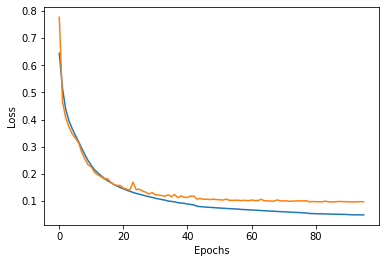

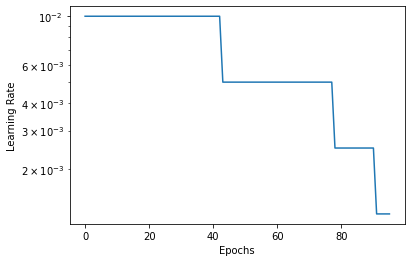

In [13]:
graph.plot(hist.history['binary_accuracy'])
graph.plot(hist.history['val_binary_accuracy'])
graph.ylabel('Accuracy')
graph.xlabel('Epochs')
graph.show()

graph.plot(hist.history['loss'])
graph.plot(hist.history['val_loss'])
graph.ylabel('Loss')
graph.xlabel('Epochs')
graph.show()

graph.plot(hist.history['lr'])
graph.ylabel('Learning Rate')
graph.xlabel('Epochs')
graph.yscale('log')
graph.show()

In [14]:
x_test, y_test = create_x_y(pair_test_data, pair_test_targets)
print(len(x_test[0]), len(y_test))


20000 20000


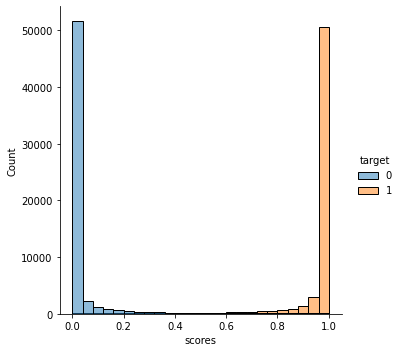

In [15]:
df_after = pd.DataFrame(
    final_model.predict(x_train),
    columns=['scores']
)
df_after['target'] = y_train

sns.displot(df_after, x='scores', hue='target',)
graph.show()

# Results

In [16]:
y_hat_test = final_model.predict(x_test).flatten()
print(y_hat_test.shape)


def prob_string(prob):
    return f'{prob:.1%}'

(20000,)


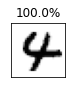

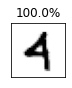

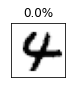

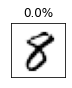

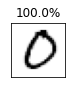

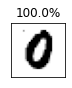

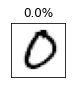

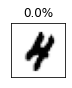

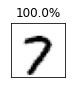

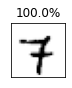

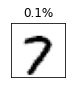

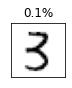

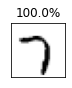

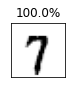

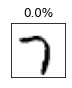

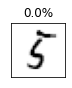

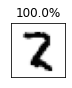

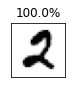

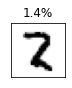

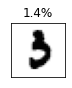

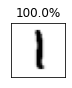

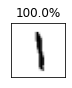

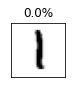

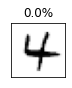

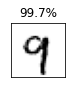

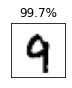

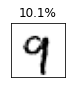

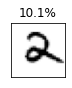

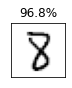

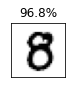

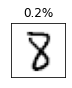

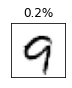

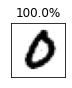

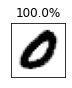

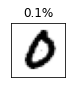

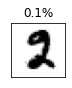

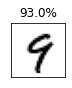

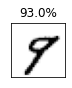

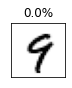

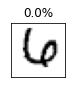

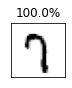

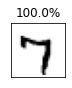

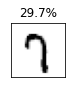

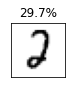

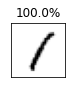

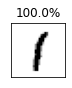

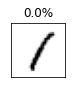

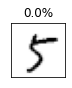

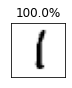

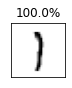

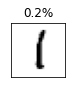

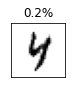

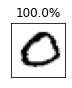

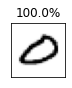

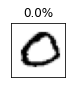

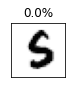

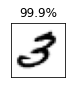

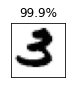

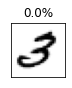

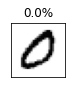

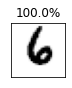

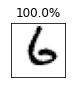

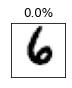

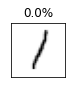

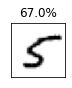

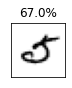

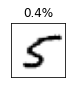

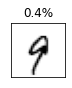

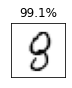

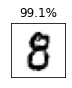

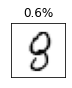

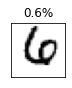

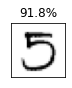

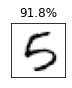

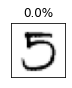

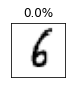

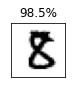

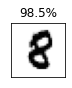

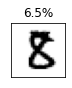

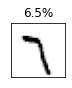

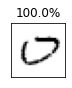

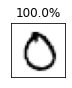

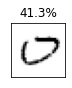

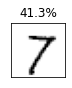

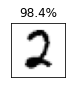

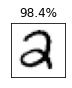

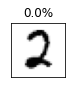

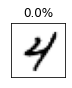

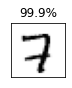

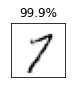

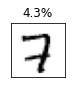

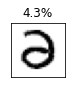

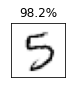

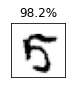

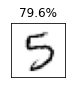

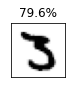

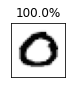

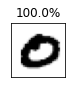

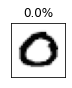

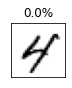

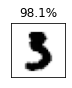

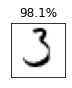

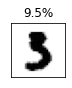

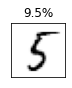

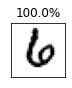

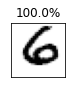

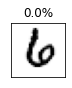

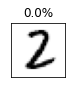

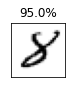

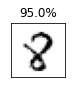

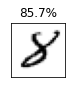

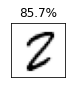

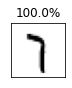

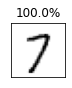

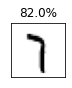

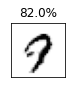

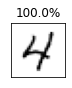

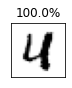

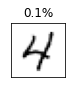

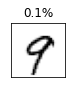

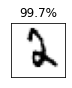

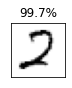

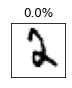

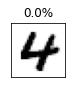

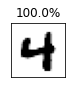

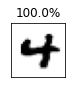

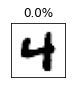

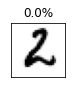

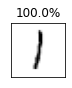

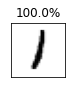

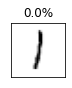

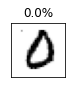

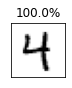

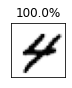

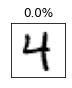

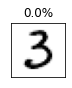

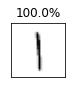

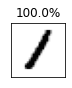

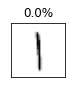

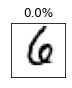

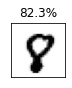

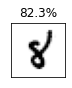

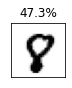

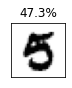

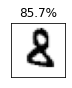

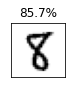

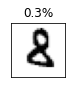

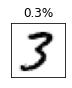

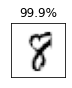

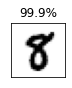

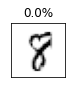

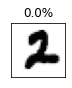

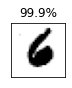

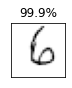

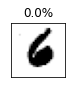

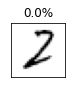

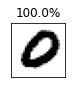

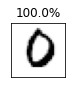

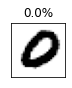

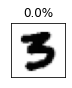

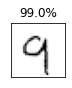

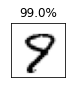

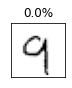

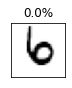

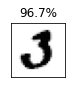

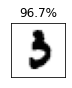

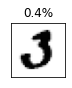

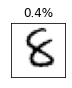

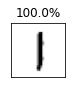

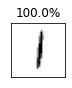

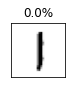

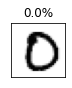

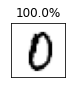

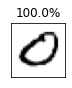

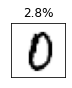

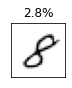

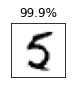

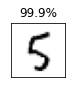

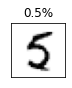

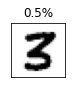

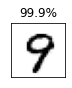

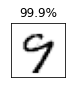

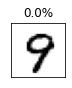

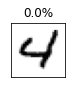

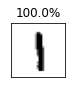

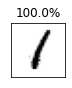

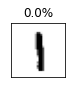

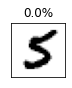

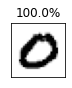

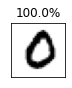

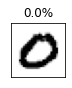

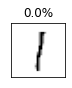

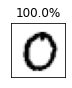

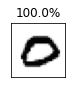

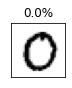

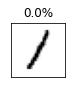

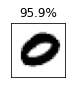

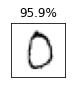

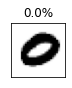

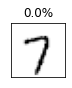

In [17]:
for w in np.random.choice(np.arange(int(len(pair_test_data) / 2)), size=50):
    even = 2*w
    odd = 2*w + 1

    plot_number(pair_test_data[even][0], prob_string(y_hat_test[even]))
    plot_number(pair_test_data[even][1], prob_string(y_hat_test[even]))
    print('='*60)

    plot_number(pair_test_data[odd][0], prob_string(y_hat_test[odd]))
    plot_number(pair_test_data[odd][1], prob_string(y_hat_test[odd]))
    print('='*60)